In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [8]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [9]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
# del cm_target[1,2,7,10,13]
cm_target = cm_target[7:10]

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    hh = generate_h(n_beta, t_len, normalize)
    bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    #x = t
    x = np.hstack((t, hh, bb))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = np.concatenate((h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (15000, 2)
Dimension - heights of Gurney flaps:  (15000, 1)
Dimension - inclination(beta):  (15000, 1)
Dimension - x:  (15000, 3)
Dimension - y:  (15000, 1)


In [21]:
x[:,0] -= 10
x[:,0] /= 5

In [22]:
x[:,0]

array([0.000e+00, 2.000e-04, 4.000e-04, ..., 9.994e-01, 9.996e-01,
       9.998e-01])

In [23]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [24]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [25]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=3)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [26]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               1024      
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [28]:
model_directory = "D:\\TrainedModels\\20221229\\3beta"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [29]:
#ckpt_name = model_directory + "20221229unsteadyPrediction_MLP_10h_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_checkpoint.h5"

#ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.1,
                                          min_delta = 1e-5, min_lr=1e-05, verbose=1)

In [30]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [31]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
10/10 [==============================] - 5s 52ms/step - loss: 0.1684 - rmse: 0.4102 - val_loss: 0.1222 - val_rmse: 0.3494 - lr: 1.0000e-04
Epoch 2/10000
10/10 [==============================] - 0s 15ms/step - loss: 0.0927 - rmse: 0.3042 - val_loss: 0.0718 - val_rmse: 0.2678 - lr: 1.0000e-04
Epoch 3/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.0631 - rmse: 0.2510 - val_loss: 0.0636 - val_rmse: 0.2520 - lr: 1.0000e-04
Epoch 4/10000
10/10 [==============================] - 0s 12ms/step - loss: 0.0629 - rmse: 0.2505 - val_loss: 0.0619 - val_rmse: 0.2486 - lr: 1.0000e-04
Epoch 5/10000
10/10 [==============================] - 0s 12ms/step - loss: 0.0599 - rmse: 0.2446 - val_loss: 0.0614 - val_rmse: 0.2476 - lr: 1.0000e-04
Epoch 6/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0608 - rmse: 0.2464 - val_loss: 0.0607 - val_rmse: 0.2463 - lr: 1.0000e-04
Epoch 7/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0593

10/10 [==============================] - 0s 11ms/step - loss: 0.0574 - rmse: 0.2394 - val_loss: 0.0592 - val_rmse: 0.2432 - lr: 1.0000e-04
Epoch 55/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0582 - rmse: 0.2411 - val_loss: 0.0591 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 56/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0583 - rmse: 0.2412 - val_loss: 0.0591 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 57/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0582 - rmse: 0.2411 - val_loss: 0.0591 - val_rmse: 0.2430 - lr: 1.0000e-04
Epoch 58/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0585 - rmse: 0.2417 - val_loss: 0.0591 - val_rmse: 0.2428 - lr: 1.0000e-04
Epoch 59/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0577 - rmse: 0.2401 - val_loss: 0.0591 - val_rmse: 0.2428 - lr: 1.0000e-04
Epoch 60/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0581 - rmse:

10/10 [==============================] - 0s 11ms/step - loss: 0.0564 - rmse: 0.2373 - val_loss: 0.0572 - val_rmse: 0.2389 - lr: 1.0000e-04
Epoch 108/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0563 - rmse: 0.2371 - val_loss: 0.0568 - val_rmse: 0.2381 - lr: 1.0000e-04
Epoch 109/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0554 - rmse: 0.2352 - val_loss: 0.0566 - val_rmse: 0.2378 - lr: 1.0000e-04
Epoch 110/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0556 - rmse: 0.2357 - val_loss: 0.0564 - val_rmse: 0.2374 - lr: 1.0000e-04
Epoch 111/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0553 - rmse: 0.2349 - val_loss: 0.0562 - val_rmse: 0.2370 - lr: 1.0000e-04
Epoch 112/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0555 - rmse: 0.2354 - val_loss: 0.0559 - val_rmse: 0.2361 - lr: 1.0000e-04
Epoch 113/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0545 -

Epoch 160/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0414 - rmse: 0.2032 - val_loss: 0.0438 - val_rmse: 0.2091 - lr: 1.0000e-04
Epoch 161/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0416 - rmse: 0.2037 - val_loss: 0.0415 - val_rmse: 0.2034 - lr: 1.0000e-04
Epoch 162/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0399 - rmse: 0.1996 - val_loss: 0.0411 - val_rmse: 0.2024 - lr: 1.0000e-04
Epoch 163/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0409 - rmse: 0.2021 - val_loss: 0.0412 - val_rmse: 0.2028 - lr: 1.0000e-04
Epoch 164/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0401 - rmse: 0.2001 - val_loss: 0.0428 - val_rmse: 0.2067 - lr: 1.0000e-04
Epoch 165/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0405 - rmse: 0.2010 - val_loss: 0.0408 - val_rmse: 0.2017 - lr: 1.0000e-04
Epoch 166/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 213/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0290 - rmse: 0.1702 - val_loss: 0.0299 - val_rmse: 0.1728 - lr: 1.0000e-04
Epoch 214/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0293 - rmse: 0.1708 - val_loss: 0.0296 - val_rmse: 0.1719 - lr: 1.0000e-04
Epoch 215/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0285 - rmse: 0.1685 - val_loss: 0.0299 - val_rmse: 0.1726 - lr: 1.0000e-04
Epoch 216/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0279 - rmse: 0.1668 - val_loss: 0.0307 - val_rmse: 0.1748 - lr: 1.0000e-04
Epoch 217/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0288 - rmse: 0.1694 - val_loss: 0.0291 - val_rmse: 0.1704 - lr: 1.0000e-04
Epoch 218/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0284 - rmse: 0.1684 - val_loss: 0.0296 - val_rmse: 0.1718 - lr: 1.0000e-04
Epoch 219/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 266/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0215 - rmse: 0.1464 - val_loss: 0.0218 - val_rmse: 0.1474 - lr: 1.0000e-04
Epoch 267/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0196 - rmse: 0.1397 - val_loss: 0.0208 - val_rmse: 0.1439 - lr: 1.0000e-04
Epoch 268/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0208 - rmse: 0.1438 - val_loss: 0.0226 - val_rmse: 0.1499 - lr: 1.0000e-04
Epoch 269/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0202 - rmse: 0.1418 - val_loss: 0.0208 - val_rmse: 0.1437 - lr: 1.0000e-04
Epoch 270/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0199 - rmse: 0.1407 - val_loss: 0.0213 - val_rmse: 0.1457 - lr: 1.0000e-04
Epoch 271/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0203 - rmse: 0.1423 - val_loss: 0.0224 - val_rmse: 0.1492 - lr: 1.0000e-04
Epoch 272/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 319/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0156 - rmse: 0.1246 - val_loss: 0.0164 - val_rmse: 0.1278 - lr: 1.0000e-04
Epoch 320/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0159 - rmse: 0.1258 - val_loss: 0.0168 - val_rmse: 0.1292 - lr: 1.0000e-04
Epoch 321/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0157 - rmse: 0.1248 - val_loss: 0.0165 - val_rmse: 0.1281 - lr: 1.0000e-04
Epoch 322/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0159 - rmse: 0.1259 - val_loss: 0.0161 - val_rmse: 0.1264 - lr: 1.0000e-04
Epoch 323/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0155 - rmse: 0.1243 - val_loss: 0.0163 - val_rmse: 0.1272 - lr: 1.0000e-04
Epoch 324/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0159 - rmse: 0.1257 - val_loss: 0.0158 - val_rmse: 0.1255 - lr: 1.0000e-04
Epoch 325/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 372/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0124 - rmse: 0.1110 - val_loss: 0.0128 - val_rmse: 0.1126 - lr: 1.0000e-04
Epoch 373/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0130 - rmse: 0.1136 - val_loss: 0.0132 - val_rmse: 0.1143 - lr: 1.0000e-04
Epoch 374/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0126 - val_rmse: 0.1119 - lr: 1.0000e-04
Epoch 375/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0127 - rmse: 0.1121 - val_loss: 0.0132 - val_rmse: 0.1144 - lr: 1.0000e-04
Epoch 376/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0132 - rmse: 0.1147 - val_loss: 0.0132 - val_rmse: 0.1144 - lr: 1.0000e-04
Epoch 377/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0130 - rmse: 0.1138 - val_loss: 0.0140 - val_rmse: 0.1181 - lr: 1.0000e-04
Epoch 378/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 425/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0112 - rmse: 0.1054 - val_loss: 0.0105 - val_rmse: 0.1020 - lr: 1.0000e-04
Epoch 426/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0117 - rmse: 0.1079 - val_loss: 0.0105 - val_rmse: 0.1023 - lr: 1.0000e-04
Epoch 427/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0100 - rmse: 0.0998 - val_loss: 0.0104 - val_rmse: 0.1014 - lr: 1.0000e-04
Epoch 428/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0106 - rmse: 0.1024 - val_loss: 0.0116 - val_rmse: 0.1075 - lr: 1.0000e-04
Epoch 429/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0101 - rmse: 0.0999 - val_loss: 0.0111 - val_rmse: 0.1049 - lr: 1.0000e-04
Epoch 430/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0108 - rmse: 0.1037 - val_loss: 0.0111 - val_rmse: 0.1050 - lr: 1.0000e-04
Epoch 431/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 478/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0087 - rmse: 0.0929 - val_loss: 0.0089 - val_rmse: 0.0942 - lr: 1.0000e-04
Epoch 479/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0096 - rmse: 0.0974 - val_loss: 0.0096 - val_rmse: 0.0976 - lr: 1.0000e-04
Epoch 480/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0090 - rmse: 0.0946 - val_loss: 0.0126 - val_rmse: 0.1118 - lr: 1.0000e-04
Epoch 481/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0101 - rmse: 0.1001 - val_loss: 0.0106 - val_rmse: 0.1024 - lr: 1.0000e-04
Epoch 482/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0098 - rmse: 0.0985 - val_loss: 0.0099 - val_rmse: 0.0989 - lr: 1.0000e-04
Epoch 483/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0090 - rmse: 0.0943 - val_loss: 0.0090 - val_rmse: 0.0945 - lr: 1.0000e-04
Epoch 484/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 531/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0078 - rmse: 0.0876 - val_loss: 0.0094 - val_rmse: 0.0964 - lr: 1.0000e-04
Epoch 532/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0080 - rmse: 0.0889 - val_loss: 0.0108 - val_rmse: 0.1035 - lr: 1.0000e-04
Epoch 533/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0095 - rmse: 0.0968 - val_loss: 0.0075 - val_rmse: 0.0860 - lr: 1.0000e-04
Epoch 534/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - rmse: 0.0861 - val_loss: 0.0076 - val_rmse: 0.0867 - lr: 1.0000e-04
Epoch 535/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0078 - rmse: 0.0876 - val_loss: 0.0090 - val_rmse: 0.0944 - lr: 1.0000e-04
Epoch 536/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0079 - rmse: 0.0883 - val_loss: 0.0075 - val_rmse: 0.0864 - lr: 1.0000e-04
Epoch 537/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 584/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0067 - rmse: 0.0813 - val_loss: 0.0070 - val_rmse: 0.0830 - lr: 1.0000e-04
Epoch 585/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0068 - rmse: 0.0819 - val_loss: 0.0069 - val_rmse: 0.0826 - lr: 1.0000e-04
Epoch 586/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0074 - rmse: 0.0855 - val_loss: 0.0067 - val_rmse: 0.0812 - lr: 1.0000e-04
Epoch 587/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - rmse: 0.0863 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 588/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0069 - rmse: 0.0825 - val_loss: 0.0071 - val_rmse: 0.0835 - lr: 1.0000e-04
Epoch 589/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0066 - rmse: 0.0808 - val_loss: 0.0064 - val_rmse: 0.0793 - lr: 1.0000e-04
Epoch 590/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 637/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0061 - val_rmse: 0.0776 - lr: 1.0000e-04
Epoch 638/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0059 - rmse: 0.0760 - val_loss: 0.0057 - val_rmse: 0.0749 - lr: 1.0000e-04
Epoch 639/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0056 - rmse: 0.0745 - val_loss: 0.0059 - val_rmse: 0.0763 - lr: 1.0000e-04
Epoch 640/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0057 - rmse: 0.0747 - val_loss: 0.0058 - val_rmse: 0.0756 - lr: 1.0000e-04
Epoch 641/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0058 - rmse: 0.0754 - val_loss: 0.0058 - val_rmse: 0.0754 - lr: 1.0000e-04
Epoch 642/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0064 - rmse: 0.0797 - val_loss: 0.0088 - val_rmse: 0.0931 - lr: 1.0000e-04
Epoch 643/10000
10/10 [==============================] - 0s 10ms/step 

Epoch 690/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0051 - rmse: 0.0708 - val_loss: 0.0068 - val_rmse: 0.0821 - lr: 1.0000e-04
Epoch 691/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0061 - rmse: 0.0779 - val_loss: 0.0082 - val_rmse: 0.0901 - lr: 1.0000e-04
Epoch 692/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0065 - rmse: 0.0799 - val_loss: 0.0086 - val_rmse: 0.0924 - lr: 1.0000e-04
Epoch 693/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0063 - rmse: 0.0786 - val_loss: 0.0070 - val_rmse: 0.0834 - lr: 1.0000e-04
Epoch 694/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0052 - rmse: 0.0718 - val_loss: 0.0062 - val_rmse: 0.0784 - lr: 1.0000e-04
Epoch 695/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0059 - rmse: 0.0763 - val_loss: 0.0067 - val_rmse: 0.0816 - lr: 1.0000e-04
Epoch 696/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 743/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0045 - rmse: 0.0663 - val_loss: 0.0044 - val_rmse: 0.0654 - lr: 1.0000e-04
Epoch 744/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0046 - rmse: 0.0670 - val_loss: 0.0045 - val_rmse: 0.0665 - lr: 1.0000e-04
Epoch 745/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0052 - rmse: 0.0715 - val_loss: 0.0046 - val_rmse: 0.0669 - lr: 1.0000e-04
Epoch 746/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0045 - val_rmse: 0.0664 - lr: 1.0000e-04
Epoch 747/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0046 - val_rmse: 0.0672 - lr: 1.0000e-04
Epoch 748/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0057 - rmse: 0.0750 - val_loss: 0.0074 - val_rmse: 0.0854 - lr: 1.0000e-04
Epoch 749/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 796/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0042 - val_rmse: 0.0640 - lr: 1.0000e-04
Epoch 797/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0043 - rmse: 0.0646 - val_loss: 0.0044 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 798/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0050 - rmse: 0.0703 - val_loss: 0.0071 - val_rmse: 0.0835 - lr: 1.0000e-04
Epoch 799/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0048 - rmse: 0.0690 - val_loss: 0.0045 - val_rmse: 0.0664 - lr: 1.0000e-04
Epoch 800/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0042 - rmse: 0.0639 - val_loss: 0.0039 - val_rmse: 0.0618 - lr: 1.0000e-04
Epoch 801/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0039 - rmse: 0.0621 - val_loss: 0.0041 - val_rmse: 0.0633 - lr: 1.0000e-04
Epoch 802/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 849/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0053 - rmse: 0.0723 - val_loss: 0.0037 - val_rmse: 0.0606 - lr: 1.0000e-04
Epoch 850/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0036 - val_rmse: 0.0591 - lr: 1.0000e-04
Epoch 851/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0035 - rmse: 0.0588 - val_loss: 0.0037 - val_rmse: 0.0602 - lr: 1.0000e-04
Epoch 852/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0037 - rmse: 0.0598 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 853/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0044 - rmse: 0.0661 - val_loss: 0.0046 - val_rmse: 0.0672 - lr: 1.0000e-04
Epoch 854/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0038 - rmse: 0.0610 - val_loss: 0.0036 - val_rmse: 0.0589 - lr: 1.0000e-04
Epoch 855/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 902/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0038 - rmse: 0.0613 - val_loss: 0.0034 - val_rmse: 0.0580 - lr: 1.0000e-04
Epoch 903/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0032 - rmse: 0.0561 - val_loss: 0.0033 - val_rmse: 0.0565 - lr: 1.0000e-04
Epoch 904/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0036 - rmse: 0.0594 - val_loss: 0.0043 - val_rmse: 0.0651 - lr: 1.0000e-04
Epoch 905/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0049 - rmse: 0.0697 - val_loss: 0.0037 - val_rmse: 0.0598 - lr: 1.0000e-04
Epoch 906/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0042 - rmse: 0.0642 - val_loss: 0.0038 - val_rmse: 0.0607 - lr: 1.0000e-04
Epoch 907/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0035 - rmse: 0.0589 - val_loss: 0.0033 - val_rmse: 0.0566 - lr: 1.0000e-04
Epoch 908/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 955/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0035 - rmse: 0.0583 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 956/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0554 - val_loss: 0.0032 - val_rmse: 0.0559 - lr: 1.0000e-04
Epoch 957/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0040 - rmse: 0.0623 - val_loss: 0.0042 - val_rmse: 0.0641 - lr: 1.0000e-04
Epoch 958/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0036 - rmse: 0.0590 - val_loss: 0.0029 - val_rmse: 0.0532 - lr: 1.0000e-04
Epoch 959/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0037 - rmse: 0.0606 - val_loss: 0.0035 - val_rmse: 0.0588 - lr: 1.0000e-04
Epoch 960/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0034 - rmse: 0.0579 - val_loss: 0.0039 - val_rmse: 0.0619 - lr: 1.0000e-04
Epoch 961/10000
10/10 [==============================] - 0s 11ms/step 

Epoch 1008/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0548 - val_loss: 0.0027 - val_rmse: 0.0508 - lr: 1.0000e-04
Epoch 1009/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0029 - rmse: 0.0529 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 1010/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0043 - rmse: 0.0647 - val_loss: 0.0041 - val_rmse: 0.0631 - lr: 1.0000e-04
Epoch 1011/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0038 - rmse: 0.0608 - val_loss: 0.0029 - val_rmse: 0.0531 - lr: 1.0000e-04
Epoch 1012/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0537 - val_loss: 0.0027 - val_rmse: 0.0516 - lr: 1.0000e-04
Epoch 1013/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0547 - val_loss: 0.0028 - val_rmse: 0.0523 - lr: 1.0000e-04
Epoch 1014/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0039 - val_rmse: 0.0617 - lr: 1.0000e-04
Epoch 1061/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0027 - rmse: 0.0512 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 1062/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 1063/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0030 - rmse: 0.0537 - val_loss: 0.0025 - val_rmse: 0.0493 - lr: 1.0000e-04
Epoch 1064/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0042 - rmse: 0.0641 - val_loss: 0.0041 - val_rmse: 0.0638 - lr: 1.0000e-04
Epoch 1065/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0035 - rmse: 0.0584 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 1066/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.

Epoch 1113/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 1114/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0479 - val_loss: 0.0030 - val_rmse: 0.0545 - lr: 1.0000e-04
Epoch 1115/10000
10/10 [==============================] - 0s 12ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0470 - lr: 1.0000e-04
Epoch 1116/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0031 - val_rmse: 0.0549 - lr: 1.0000e-04
Epoch 1117/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0507 - val_loss: 0.0031 - val_rmse: 0.0554 - lr: 1.0000e-04
Epoch 1118/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0032 - rmse: 0.0555 - val_loss: 0.0031 - val_rmse: 0.0546 - lr: 1.0000e-04
Epoch 1119/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0567 - val_loss: 0.0053 - val_rmse: 0.0719 - lr: 1.0000e-04
Epoch 1166/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0045 - rmse: 0.0662 - val_loss: 0.0029 - val_rmse: 0.0535 - lr: 1.0000e-04
Epoch 1167/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0501 - val_loss: 0.0024 - val_rmse: 0.0482 - lr: 1.0000e-04
Epoch 1168/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0485 - val_loss: 0.0023 - val_rmse: 0.0468 - lr: 1.0000e-04
Epoch 1169/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 1170/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0027 - val_rmse: 0.0511 - lr: 1.0000e-04
Epoch 1171/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

Epoch 1218/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0482 - val_loss: 0.0040 - val_rmse: 0.0627 - lr: 1.0000e-04
Epoch 1219/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0545 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 1220/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0032 - rmse: 0.0556 - val_loss: 0.0021 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 1221/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0452 - val_loss: 0.0021 - val_rmse: 0.0453 - lr: 1.0000e-04
Epoch 1222/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0464 - val_loss: 0.0020 - val_rmse: 0.0438 - lr: 1.0000e-04
Epoch 1223/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0024 - val_rmse: 0.0478 - lr: 1.0000e-04
Epoch 1224/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0487 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 1271/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0506 - val_loss: 0.0052 - val_rmse: 0.0712 - lr: 1.0000e-04
Epoch 1272/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0039 - rmse: 0.0617 - val_loss: 0.0020 - val_rmse: 0.0442 - lr: 1.0000e-04
Epoch 1273/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0036 - rmse: 0.0591 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 1274/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 1275/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0025 - rmse: 0.0496 - val_loss: 0.0020 - val_rmse: 0.0437 - lr: 1.0000e-04
Epoch 1276/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

Epoch 1323/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0426 - val_loss: 0.0018 - val_rmse: 0.0421 - lr: 1.0000e-04
Epoch 1324/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0411 - val_loss: 0.0019 - val_rmse: 0.0432 - lr: 1.0000e-04
Epoch 1325/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0445 - val_loss: 0.0025 - val_rmse: 0.0494 - lr: 1.0000e-04
Epoch 1326/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0455 - val_loss: 0.0021 - val_rmse: 0.0448 - lr: 1.0000e-04
Epoch 1327/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 1.0000e-04
Epoch 1328/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0036 - rmse: 0.0593 - val_loss: 0.0030 - val_rmse: 0.0542 - lr: 1.0000e-04
Epoch 1329/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0025 - rmse: 0.0494 - val_loss: 0.0041 - val_rmse: 0.0636 - lr: 1.0000e-04
Epoch 1376/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0566 - val_loss: 0.0022 - val_rmse: 0.0462 - lr: 1.0000e-04
Epoch 1377/10000
10/10 [==============================] - 0s 12ms/step - loss: 0.0019 - rmse: 0.0422 - val_loss: 0.0019 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 1378/10000
10/10 [==============================] - 0s 19ms/step - loss: 0.0025 - rmse: 0.0493 - val_loss: 0.0021 - val_rmse: 0.0454 - lr: 1.0000e-04
Epoch 1379/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0018 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 1380/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0520 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 1381/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

Epoch 1428/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0037 - rmse: 0.0601 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 1429/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0032 - val_rmse: 0.0556 - lr: 1.0000e-04
Epoch 1430/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0027 - val_rmse: 0.0509 - lr: 1.0000e-04
Epoch 1431/10000
10/10 [==============================] - 0s 12ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0030 - val_rmse: 0.0540 - lr: 1.0000e-04
Epoch 1432/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0542 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 1433/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0510 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 1434/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0423 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 1481/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0024 - val_rmse: 0.0480 - lr: 1.0000e-04
Epoch 1482/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0436 - val_loss: 0.0018 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 1483/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0019 - val_rmse: 0.0426 - lr: 1.0000e-04
Epoch 1484/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0016 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 1485/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0412 - val_loss: 0.0016 - val_rmse: 0.0393 - lr: 1.0000e-04
Epoch 1486/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

Epoch 1533/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0408 - val_loss: 0.0015 - val_rmse: 0.0382 - lr: 1.0000e-04
Epoch 1534/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0477 - val_loss: 0.0036 - val_rmse: 0.0590 - lr: 1.0000e-04
Epoch 1535/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0424 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 1536/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0388 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 1537/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0015 - val_rmse: 0.0384 - lr: 1.0000e-04
Epoch 1538/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0406 - val_loss: 0.0025 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 1539/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0475 - val_loss: 0.0017 - val_rmse: 0.0405 - lr: 1.0000e-04
Epoch 1586/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0017 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 1587/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0441 - val_loss: 0.0022 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 1588/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0516 - val_loss: 0.0034 - val_rmse: 0.0578 - lr: 1.0000e-04
Epoch 1589/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0465 - val_loss: 0.0027 - val_rmse: 0.0513 - lr: 1.0000e-04
Epoch 1590/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 1591/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

Epoch 1638/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 1639/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0404 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 1640/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0027 - val_rmse: 0.0512 - lr: 1.0000e-04
Epoch 1641/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0522 - val_loss: 0.0049 - val_rmse: 0.0698 - lr: 1.0000e-04
Epoch 1642/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0546 - val_loss: 0.0019 - val_rmse: 0.0423 - lr: 1.0000e-04
Epoch 1643/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0461 - val_loss: 0.0029 - val_rmse: 0.0528 - lr: 1.0000e-04
Epoch 1644/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0350 - val_loss: 0.0014 - val_rmse: 0.0360 - lr: 1.0000e-04
Epoch 1691/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0347 - val_loss: 0.0014 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 1692/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0349 - val_loss: 0.0014 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 1693/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0358 - val_loss: 0.0013 - val_rmse: 0.0353 - lr: 1.0000e-04
Epoch 1694/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0359 - val_loss: 0.0015 - val_rmse: 0.0378 - lr: 1.0000e-04
Epoch 1695/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 1696/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

Epoch 1743/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 0.0013 - val_rmse: 0.0350 - lr: 1.0000e-04
Epoch 1744/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0018 - val_rmse: 0.0409 - lr: 1.0000e-04
Epoch 1745/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0466 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 1746/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0462 - val_loss: 0.0024 - val_rmse: 0.0483 - lr: 1.0000e-04
Epoch 1747/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0017 - val_rmse: 0.0399 - lr: 1.0000e-04
Epoch 1748/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 0.0022 - val_rmse: 0.0456 - lr: 1.0000e-04
Epoch 1749/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0421 - val_loss: 0.0035 - val_rmse: 0.0586 - lr: 1.0000e-04
Epoch 1796/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0031 - rmse: 0.0550 - val_loss: 0.0038 - val_rmse: 0.0608 - lr: 1.0000e-04
Epoch 1797/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0030 - rmse: 0.0544 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 1798/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0407 - val_loss: 0.0027 - val_rmse: 0.0514 - lr: 1.0000e-04
Epoch 1799/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0484 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 1800/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0374 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 1801/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.

Epoch 1848/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0041 - rmse: 0.0634 - val_loss: 0.0053 - val_rmse: 0.0724 - lr: 1.0000e-04
Epoch 1849/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0024 - rmse: 0.0480 - val_loss: 0.0014 - val_rmse: 0.0362 - lr: 1.0000e-04
Epoch 1850/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 1851/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0012 - val_rmse: 0.0336 - lr: 1.0000e-04
Epoch 1852/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0327 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 1853/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0321 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 1854/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 1901/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0021 - val_rmse: 0.0450 - lr: 1.0000e-04
Epoch 1902/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 1903/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0312 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 1904/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0384 - val_loss: 0.0013 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 1905/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0377 - val_loss: 0.0014 - val_rmse: 0.0366 - lr: 1.0000e-04
Epoch 1906/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

Epoch 1953/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0014 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 1954/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0427 - val_loss: 0.0025 - val_rmse: 0.0497 - lr: 1.0000e-04
Epoch 1955/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0425 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 1956/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 1957/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0359 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 1958/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0372 - val_loss: 0.0023 - val_rmse: 0.0475 - lr: 1.0000e-04
Epoch 1959/10000
10/10 [==============================] - 0s 11m

10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0017 - val_rmse: 0.0408 - lr: 1.0000e-04
Epoch 2006/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0333 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 2007/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 2008/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0026 - rmse: 0.0500 - val_loss: 0.0039 - val_rmse: 0.0622 - lr: 1.0000e-04
Epoch 2009/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0031 - rmse: 0.0553 - val_loss: 0.0014 - val_rmse: 0.0369 - lr: 1.0000e-04
Epoch 2010/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0025 - val_rmse: 0.0496 - lr: 1.0000e-04
Epoch 2011/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.

10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0409 - val_loss: 0.0012 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 2058/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0453 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 2059/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0014 - val_rmse: 0.0367 - lr: 1.0000e-04
Epoch 2060/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0434 - val_loss: 0.0030 - val_rmse: 0.0539 - lr: 1.0000e-04
Epoch 2061/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0021 - rmse: 0.0450 - val_loss: 0.0012 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 2062/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0021 - rmse: 0.0446 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 2063/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.

10/10 [==============================] - 0s 11ms/step - loss: 9.1696e-04 - rmse: 0.0290 - val_loss: 9.3121e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 2110/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0344 - val_loss: 9.3276e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 2111/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.7245e-04 - rmse: 0.0282 - val_loss: 9.3593e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 2112/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0312 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 2113/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0431 - val_loss: 0.0019 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 2114/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 2115/10000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 11ms/step - loss: 9.4414e-04 - rmse: 0.0295 - val_loss: 9.8692e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 2162/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0376 - val_loss: 9.2647e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 2163/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0014 - val_rmse: 0.0363 - lr: 1.0000e-04
Epoch 2164/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0401 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 2165/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0474 - val_loss: 0.0055 - val_rmse: 0.0734 - lr: 1.0000e-04
Epoch 2166/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0022 - rmse: 0.0457 - val_loss: 0.0018 - val_rmse: 0.0413 - lr: 1.0000e-04
Epoch 2167/10000
10/10 [==============================] - 0s 11ms/ste

Epoch 2213/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 2214/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0438 - val_loss: 0.0028 - val_rmse: 0.0524 - lr: 1.0000e-04
Epoch 2215/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0369 - val_loss: 0.0017 - val_rmse: 0.0407 - lr: 1.0000e-04
Epoch 2216/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 9.4888e-04 - val_rmse: 0.0295 - lr: 1.0000e-04
Epoch 2217/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0355 - val_loss: 0.0018 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 2218/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0023 - rmse: 0.0469 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 2219/10000
10/10 [==============================] - 0s

Epoch 2265/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 2266/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0015 - rmse: 0.0378 - val_loss: 0.0023 - val_rmse: 0.0476 - lr: 1.0000e-04
Epoch 2267/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0414 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 2268/10000
10/10 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 2269/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0340 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 2270/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0337 - val_loss: 8.5708e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 2271/10000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0363 - val_loss: 0.0015 - val_rmse: 0.0381 - lr: 1.0000e-04
Epoch 2318/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0371 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 2319/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.8949e-04 - rmse: 0.0285 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 2320/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0308 - val_loss: 0.0011 - val_rmse: 0.0327 - lr: 1.0000e-04
Epoch 2321/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 2322/10000
10/10 [==============================] - 0s 10ms/step - loss: 8.5426e-04 - rmse: 0.0279 - val_loss: 0.0015 - val_rmse: 0.0380 - lr: 1.0000e-04
Epoch 2323/10000
10/10 [==============================] - 0s 10ms/step - 

Epoch 2369/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.4642e-04 - rmse: 0.0295 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 2370/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.0532e-04 - rmse: 0.0270 - val_loss: 8.0109e-04 - val_rmse: 0.0269 - lr: 1.0000e-04
Epoch 2371/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 0.0013 - val_rmse: 0.0356 - lr: 1.0000e-04
Epoch 2372/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0322 - val_loss: 8.6740e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 2373/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0030 - val_rmse: 0.0538 - lr: 1.0000e-04
Epoch 2374/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0034 - rmse: 0.0574 - val_loss: 0.0038 - val_rmse: 0.0609 - lr: 1.0000e-04
Epoch 2375/10000
10/10 [========================

10/10 [==============================] - 0s 11ms/step - loss: 8.2992e-04 - rmse: 0.0275 - val_loss: 9.0835e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 2421/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 2422/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0366 - val_loss: 0.0018 - val_rmse: 0.0415 - lr: 1.0000e-04
Epoch 2423/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 2424/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0386 - val_loss: 0.0020 - val_rmse: 0.0436 - lr: 1.0000e-04
Epoch 2425/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0439 - val_loss: 8.0532e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 2426/10000
10/10 [==============================] - 0s 11ms/ste

10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0323 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 2472/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0367 - val_loss: 0.0013 - val_rmse: 0.0355 - lr: 1.0000e-04
Epoch 2473/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.4586e-04 - rmse: 0.0295 - val_loss: 7.3925e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 2474/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.8695e-04 - rmse: 0.0285 - val_loss: 7.3359e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 2475/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.1251e-04 - rmse: 0.0252 - val_loss: 7.3692e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 2476/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.8650e-04 - rmse: 0.0247 - val_loss: 7.2247e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 2477/10000
10/10 [=========================

10/10 [==============================] - 0s 11ms/step - loss: 9.4572e-04 - rmse: 0.0295 - val_loss: 0.0012 - val_rmse: 0.0342 - lr: 1.0000e-04
Epoch 2523/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0016 - rmse: 0.0391 - val_loss: 0.0023 - val_rmse: 0.0467 - lr: 1.0000e-04
Epoch 2524/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0013 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 2525/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.0232e-04 - rmse: 0.0287 - val_loss: 7.5060e-04 - val_rmse: 0.0260 - lr: 1.0000e-04
Epoch 2526/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.7773e-04 - rmse: 0.0283 - val_loss: 0.0018 - val_rmse: 0.0420 - lr: 1.0000e-04
Epoch 2527/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0015 - rmse: 0.0371 - val_loss: 0.0014 - val_rmse: 0.0368 - lr: 1.0000e-04
Epoch 2528/10000
10/10 [==============================] - 0s 11ms

10/10 [==============================] - 0s 11ms/step - loss: 8.8595e-04 - rmse: 0.0284 - val_loss: 9.2700e-04 - val_rmse: 0.0292 - lr: 1.0000e-04
Epoch 2574/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0312 - val_loss: 8.0759e-04 - val_rmse: 0.0270 - lr: 1.0000e-04
Epoch 2575/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.3521e-04 - rmse: 0.0293 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 2576/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0028 - rmse: 0.0523 - val_loss: 0.0047 - val_rmse: 0.0678 - lr: 1.0000e-04
Epoch 2577/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0517 - val_loss: 0.0015 - val_rmse: 0.0373 - lr: 1.0000e-04
Epoch 2578/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 9.7931e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 2579/10000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 11ms/step - loss: 7.1968e-04 - rmse: 0.0254 - val_loss: 9.3961e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 2625/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0330 - val_loss: 6.7598e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 2626/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.7083e-04 - rmse: 0.0244 - val_loss: 7.3009e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 2627/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.8548e-04 - rmse: 0.0247 - val_loss: 7.3596e-04 - val_rmse: 0.0257 - lr: 1.0000e-04
Epoch 2628/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.3040e-04 - rmse: 0.0256 - val_loss: 0.0025 - val_rmse: 0.0491 - lr: 1.0000e-04
Epoch 2629/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0042 - rmse: 0.0640 - val_loss: 0.0033 - val_rmse: 0.0568 - lr: 1.0000e-04
Epoch 2630/10000
10/10 [=========================

10/10 [==============================] - 0s 11ms/step - loss: 6.9394e-04 - rmse: 0.0248 - val_loss: 6.8992e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 2676/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0013 - rmse: 0.0348 - val_loss: 0.0017 - val_rmse: 0.0401 - lr: 1.0000e-04
Epoch 2677/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0418 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 2678/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.3784e-04 - rmse: 0.0276 - val_loss: 7.6946e-04 - val_rmse: 0.0263 - lr: 1.0000e-04
Epoch 2679/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.3912e-04 - rmse: 0.0276 - val_loss: 6.8813e-04 - val_rmse: 0.0247 - lr: 1.0000e-04
Epoch 2680/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.3065e-04 - rmse: 0.0256 - val_loss: 8.3671e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 2681/10000
10/10 [=========================

10/10 [==============================] - 0s 11ms/step - loss: 7.1338e-04 - rmse: 0.0252 - val_loss: 7.8615e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 2727/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.5266e-04 - rmse: 0.0240 - val_loss: 6.3871e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 2728/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.9531e-04 - rmse: 0.0268 - val_loss: 6.9789e-04 - val_rmse: 0.0249 - lr: 1.0000e-04
Epoch 2729/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.5284e-04 - rmse: 0.0296 - val_loss: 0.0016 - val_rmse: 0.0386 - lr: 1.0000e-04
Epoch 2730/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.5372e-04 - rmse: 0.0279 - val_loss: 6.6015e-04 - val_rmse: 0.0241 - lr: 1.0000e-04
Epoch 2731/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.9024e-04 - rmse: 0.0302 - val_loss: 6.5400e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 2732/10000
10/10 [=============

Epoch 2777/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.3139e-04 - rmse: 0.0256 - val_loss: 8.3047e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 2778/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.6800e-04 - rmse: 0.0263 - val_loss: 6.3682e-04 - val_rmse: 0.0237 - lr: 1.0000e-04
Epoch 2779/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0342 - val_loss: 0.0015 - val_rmse: 0.0371 - lr: 1.0000e-04
Epoch 2780/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0316 - val_loss: 8.9083e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 2781/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.1191e-04 - rmse: 0.0231 - val_loss: 6.7797e-04 - val_rmse: 0.0245 - lr: 1.0000e-04
Epoch 2782/10000
10/10 [==============================] - 0s 11ms/step - loss: 5.8338e-04 - rmse: 0.0225 - val_loss: 6.5546e-04 - val_rmse: 0.0240 - lr: 1.0000e-04
Epoch 2783/10000
10/10 [====

Epoch 2828/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.7266e-04 - rmse: 0.0264 - val_loss: 0.0017 - val_rmse: 0.0402 - lr: 1.0000e-04
Epoch 2829/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0405 - val_loss: 0.0025 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 2830/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0413 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 2831/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.7011e-04 - rmse: 0.0243 - val_loss: 6.9156e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 2832/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.4219e-04 - rmse: 0.0258 - val_loss: 8.7326e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 2833/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.9740e-04 - rmse: 0.0268 - val_loss: 6.2250e-04 - val_rmse: 0.0234 - lr: 1.0000e-04
Epoch 2834/10000
10/10 [============

Epoch 2879/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.7388e-04 - rmse: 0.0264 - val_loss: 8.4546e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 2880/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.8828e-04 - rmse: 0.0267 - val_loss: 6.8494e-04 - val_rmse: 0.0246 - lr: 1.0000e-04
Epoch 2881/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 9.8306e-04 - val_rmse: 0.0301 - lr: 1.0000e-04
Epoch 2882/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0358 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 1.0000e-04
Epoch 2883/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0364 - val_loss: 0.0013 - val_rmse: 0.0347 - lr: 1.0000e-04
Epoch 2884/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.5391e-04 - rmse: 0.0296 - val_loss: 7.1760e-04 - val_rmse: 0.0253 - lr: 1.0000e-04
Epoch 2885/10000
10/10 [============

10/10 [==============================] - 0s 11ms/step - loss: 0.0033 - rmse: 0.0565 - val_loss: 0.0058 - val_rmse: 0.0754 - lr: 1.0000e-04
Epoch 2930/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0027 - rmse: 0.0513 - val_loss: 0.0033 - val_rmse: 0.0570 - lr: 1.0000e-04
Epoch 2931/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0398 - val_loss: 0.0021 - val_rmse: 0.0447 - lr: 1.0000e-04
Epoch 2932/10000
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0332 - val_loss: 9.7794e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 2933/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.0689e-04 - rmse: 0.0251 - val_loss: 6.3467e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 2934/10000
10/10 [==============================] - 0s 13ms/step - loss: 5.7776e-04 - rmse: 0.0224 - val_loss: 5.7987e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 2935/10000
10/10 [==============================] - 0s 

Epoch 2980/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.1501e-04 - rmse: 0.0232 - val_loss: 8.8680e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 2981/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0331 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 2982/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.0524e-04 - rmse: 0.0251 - val_loss: 6.9060e-04 - val_rmse: 0.0248 - lr: 1.0000e-04
Epoch 2983/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.0674e-04 - rmse: 0.0251 - val_loss: 7.2191e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 2984/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0324 - val_loss: 0.0021 - val_rmse: 0.0445 - lr: 1.0000e-04
Epoch 2985/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0362 - val_loss: 0.0013 - val_rmse: 0.0352 - lr: 1.0000e-04
Epoch 2986/10000
10/10 [================

Epoch 3031/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0017 - rmse: 0.0400 - val_loss: 0.0016 - val_rmse: 0.0390 - lr: 1.0000e-04
Epoch 3032/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0018 - rmse: 0.0409 - val_loss: 7.1052e-04 - val_rmse: 0.0252 - lr: 1.0000e-04
Epoch 3033/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.6526e-04 - rmse: 0.0242 - val_loss: 5.9573e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 3034/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.3480e-04 - rmse: 0.0256 - val_loss: 6.6219e-04 - val_rmse: 0.0242 - lr: 1.0000e-04
Epoch 3035/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.7693e-04 - rmse: 0.0300 - val_loss: 6.3031e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 3036/10000
10/10 [==============================] - 0s 11ms/step - loss: 7.1976e-04 - rmse: 0.0253 - val_loss: 7.2529e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 3037/10000
10/10 [====

10/10 [==============================] - 0s 11ms/step - loss: 6.0340e-04 - rmse: 0.0229 - val_loss: 9.9260e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 3082/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.2564e-04 - rmse: 0.0291 - val_loss: 5.3849e-04 - val_rmse: 0.0215 - lr: 1.0000e-04
Epoch 3083/10000
10/10 [==============================] - 0s 10ms/step - loss: 5.6361e-04 - rmse: 0.0220 - val_loss: 5.9372e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 3084/10000
10/10 [==============================] - 0s 11ms/step - loss: 5.8641e-04 - rmse: 0.0226 - val_loss: 5.5367e-04 - val_rmse: 0.0218 - lr: 1.0000e-04
Epoch 3085/10000
10/10 [==============================] - 0s 11ms/step - loss: 5.2996e-04 - rmse: 0.0213 - val_loss: 5.4465e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 3086/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.6504e-04 - rmse: 0.0197 - val_loss: 5.3243e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 3087/10000
10/10 [=========

Epoch 3132/10000
10/10 [==============================] - 0s 11ms/step - loss: 6.9883e-04 - rmse: 0.0249 - val_loss: 0.0014 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 3133/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.8040e-04 - rmse: 0.0283 - val_loss: 7.8336e-04 - val_rmse: 0.0266 - lr: 1.0000e-04
Epoch 3134/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0019 - rmse: 0.0432 - val_loss: 0.0015 - val_rmse: 0.0383 - lr: 1.0000e-04
Epoch 3135/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0020 - rmse: 0.0442 - val_loss: 0.0017 - val_rmse: 0.0398 - lr: 1.0000e-04
Epoch 3136/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 8.7145e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 3137/10000
10/10 [==============================] - 0s 11ms/step - loss: 9.3616e-04 - rmse: 0.0293 - val_loss: 6.1332e-04 - val_rmse: 0.0231 - lr: 1.0000e-04
Epoch 3138/10000
10/10 [================

Epoch 3183/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 5.1997e-04 - val_rmse: 0.0210 - lr: 1.0000e-04
Epoch 3184/10000
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0336 - val_loss: 0.0011 - val_rmse: 0.0322 - lr: 1.0000e-04
Epoch 3185/10000
10/10 [==============================] - 0s 11ms/step - loss: 8.8660e-04 - rmse: 0.0284 - val_loss: 5.1664e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 3186/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.7748e-04 - rmse: 0.0200 - val_loss: 5.7543e-04 - val_rmse: 0.0223 - lr: 1.0000e-04
Epoch 3187/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.8571e-04 - rmse: 0.0202 - val_loss: 5.9993e-04 - val_rmse: 0.0228 - lr: 1.0000e-04
Epoch 3188/10000
10/10 [==============================] - 0s 11ms/step - loss: 5.0561e-04 - rmse: 0.0207 - val_loss: 7.4667e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 3189/10000
10/10 [====

10/10 [==============================] - 0s 11ms/step - loss: 4.2564e-04 - rmse: 0.0186 - val_loss: 4.5851e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3233/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0929e-04 - rmse: 0.0182 - val_loss: 4.6072e-04 - val_rmse: 0.0196 - lr: 1.0000e-05
Epoch 3234/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.1892e-04 - rmse: 0.0185 - val_loss: 4.5903e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3235/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.1680e-04 - rmse: 0.0184 - val_loss: 4.6010e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3236/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.1552e-04 - rmse: 0.0184 - val_loss: 4.5957e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3237/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0631e-04 - rmse: 0.0181 - val_loss: 4.5990e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3238/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 4.1476e-04 - rmse: 0.0183 - val_loss: 4.5586e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3283/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.2136e-04 - rmse: 0.0185 - val_loss: 4.5842e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3284/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0572e-04 - rmse: 0.0181 - val_loss: 4.5568e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3285/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.2205e-04 - rmse: 0.0185 - val_loss: 4.5384e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3286/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0938e-04 - rmse: 0.0182 - val_loss: 4.5633e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3287/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.2027e-04 - rmse: 0.0185 - val_loss: 4.5562e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3288/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 4.1364e-04 - rmse: 0.0183 - val_loss: 4.5839e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3333/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.1208e-04 - rmse: 0.0183 - val_loss: 4.5316e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3334/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.1191e-04 - rmse: 0.0183 - val_loss: 4.5383e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3335/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.1773e-04 - rmse: 0.0184 - val_loss: 4.5510e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3336/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.0906e-04 - rmse: 0.0182 - val_loss: 4.5726e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3337/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.0787e-04 - rmse: 0.0182 - val_loss: 4.6031e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3338/10000
10/10 [=========

10/10 [==============================] - 0s 14ms/step - loss: 4.1923e-04 - rmse: 0.0185 - val_loss: 4.4848e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3383/10000
10/10 [==============================] - 0s 12ms/step - loss: 4.0190e-04 - rmse: 0.0180 - val_loss: 4.4732e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3384/10000
10/10 [==============================] - 0s 13ms/step - loss: 4.0617e-04 - rmse: 0.0181 - val_loss: 4.4636e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3385/10000
10/10 [==============================] - 0s 14ms/step - loss: 3.9761e-04 - rmse: 0.0179 - val_loss: 4.4784e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3386/10000
10/10 [==============================] - 0s 15ms/step - loss: 4.1171e-04 - rmse: 0.0183 - val_loss: 4.6122e-04 - val_rmse: 0.0196 - lr: 1.0000e-05
Epoch 3387/10000
10/10 [==============================] - 0s 14ms/step - loss: 4.0677e-04 - rmse: 0.0181 - val_loss: 4.4618e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3388/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 4.0876e-04 - rmse: 0.0182 - val_loss: 4.4210e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3433/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0242e-04 - rmse: 0.0180 - val_loss: 4.4362e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3434/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0234e-04 - rmse: 0.0180 - val_loss: 4.4752e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3435/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0670e-04 - rmse: 0.0181 - val_loss: 4.4167e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3436/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.1090e-04 - rmse: 0.0182 - val_loss: 4.4238e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3437/10000
10/10 [==============================] - 0s 13ms/step - loss: 3.8930e-04 - rmse: 0.0176 - val_loss: 4.4547e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3438/10000
10/10 [=========

10/10 [==============================] - 0s 12ms/step - loss: 4.1555e-04 - rmse: 0.0184 - val_loss: 4.5281e-04 - val_rmse: 0.0194 - lr: 1.0000e-05
Epoch 3483/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0366e-04 - rmse: 0.0180 - val_loss: 4.3797e-04 - val_rmse: 0.0190 - lr: 1.0000e-05
Epoch 3484/10000
10/10 [==============================] - 0s 11ms/step - loss: 4.0381e-04 - rmse: 0.0180 - val_loss: 4.3643e-04 - val_rmse: 0.0189 - lr: 1.0000e-05
Epoch 3485/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.9941e-04 - rmse: 0.0179 - val_loss: 4.4401e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3486/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.9787e-04 - rmse: 0.0179 - val_loss: 4.4456e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3487/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.0525e-04 - rmse: 0.0181 - val_loss: 4.4128e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3488/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 4.2122e-04 - rmse: 0.0185 - val_loss: 4.5878e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3533/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.0442e-04 - rmse: 0.0181 - val_loss: 4.6705e-04 - val_rmse: 0.0197 - lr: 1.0000e-05
Epoch 3534/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.0928e-04 - rmse: 0.0182 - val_loss: 4.3847e-04 - val_rmse: 0.0190 - lr: 1.0000e-05
Epoch 3535/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.0657e-04 - rmse: 0.0181 - val_loss: 4.3326e-04 - val_rmse: 0.0188 - lr: 1.0000e-05
Epoch 3536/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.7867e-04 - rmse: 0.0173 - val_loss: 4.3637e-04 - val_rmse: 0.0189 - lr: 1.0000e-05
Epoch 3537/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.1147e-04 - rmse: 0.0183 - val_loss: 4.3926e-04 - val_rmse: 0.0190 - lr: 1.0000e-05
Epoch 3538/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 4.0256e-04 - rmse: 0.0180 - val_loss: 4.3004e-04 - val_rmse: 0.0188 - lr: 1.0000e-05
Epoch 3583/10000
10/10 [==============================] - 0s 10ms/step - loss: 4.0863e-04 - rmse: 0.0182 - val_loss: 4.2628e-04 - val_rmse: 0.0187 - lr: 1.0000e-05
Epoch 3584/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.7237e-04 - rmse: 0.0171 - val_loss: 4.2485e-04 - val_rmse: 0.0186 - lr: 1.0000e-05
Epoch 3585/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.9379e-04 - rmse: 0.0178 - val_loss: 4.2249e-04 - val_rmse: 0.0186 - lr: 1.0000e-05
Epoch 3586/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.8244e-04 - rmse: 0.0174 - val_loss: 4.2541e-04 - val_rmse: 0.0186 - lr: 1.0000e-05
Epoch 3587/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.8890e-04 - rmse: 0.0176 - val_loss: 4.2855e-04 - val_rmse: 0.0187 - lr: 1.0000e-05
Epoch 3588/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.9118e-04 - rmse: 0.0177 - val_loss: 4.1565e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 3633/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.7036e-04 - rmse: 0.0171 - val_loss: 4.1575e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 3634/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.8231e-04 - rmse: 0.0174 - val_loss: 4.1918e-04 - val_rmse: 0.0185 - lr: 1.0000e-05
Epoch 3635/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.9501e-04 - rmse: 0.0178 - val_loss: 4.5753e-04 - val_rmse: 0.0195 - lr: 1.0000e-05
Epoch 3636/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.9922e-04 - rmse: 0.0179 - val_loss: 4.2163e-04 - val_rmse: 0.0185 - lr: 1.0000e-05
Epoch 3637/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.9860e-04 - rmse: 0.0179 - val_loss: 4.4330e-04 - val_rmse: 0.0191 - lr: 1.0000e-05
Epoch 3638/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.7836e-04 - rmse: 0.0173 - val_loss: 4.3862e-04 - val_rmse: 0.0190 - lr: 1.0000e-05
Epoch 3683/10000
10/10 [==============================] - 0s 12ms/step - loss: 3.8162e-04 - rmse: 0.0174 - val_loss: 4.1304e-04 - val_rmse: 0.0183 - lr: 1.0000e-05
Epoch 3684/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.8542e-04 - rmse: 0.0175 - val_loss: 4.1507e-04 - val_rmse: 0.0183 - lr: 1.0000e-05
Epoch 3685/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.8917e-04 - rmse: 0.0176 - val_loss: 4.1141e-04 - val_rmse: 0.0182 - lr: 1.0000e-05
Epoch 3686/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.8707e-04 - rmse: 0.0176 - val_loss: 4.1613e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 3687/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6891e-04 - rmse: 0.0170 - val_loss: 4.2600e-04 - val_rmse: 0.0186 - lr: 1.0000e-05
Epoch 3688/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 4.0104e-04 - rmse: 0.0180 - val_loss: 4.2107e-04 - val_rmse: 0.0185 - lr: 1.0000e-05
Epoch 3733/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6755e-04 - rmse: 0.0170 - val_loss: 4.1691e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 3734/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.7895e-04 - rmse: 0.0173 - val_loss: 4.1233e-04 - val_rmse: 0.0183 - lr: 1.0000e-05
Epoch 3735/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.8734e-04 - rmse: 0.0176 - val_loss: 4.2831e-04 - val_rmse: 0.0187 - lr: 1.0000e-05
Epoch 3736/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6600e-04 - rmse: 0.0170 - val_loss: 4.4533e-04 - val_rmse: 0.0192 - lr: 1.0000e-05
Epoch 3737/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.9399e-04 - rmse: 0.0178 - val_loss: 4.1934e-04 - val_rmse: 0.0185 - lr: 1.0000e-05
Epoch 3738/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.8250e-04 - rmse: 0.0174 - val_loss: 4.0067e-04 - val_rmse: 0.0180 - lr: 1.0000e-05
Epoch 3783/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.6323e-04 - rmse: 0.0169 - val_loss: 4.0745e-04 - val_rmse: 0.0181 - lr: 1.0000e-05
Epoch 3784/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.7671e-04 - rmse: 0.0173 - val_loss: 4.2017e-04 - val_rmse: 0.0185 - lr: 1.0000e-05
Epoch 3785/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.7637e-04 - rmse: 0.0173 - val_loss: 4.2269e-04 - val_rmse: 0.0186 - lr: 1.0000e-05
Epoch 3786/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.8053e-04 - rmse: 0.0174 - val_loss: 4.0179e-04 - val_rmse: 0.0180 - lr: 1.0000e-05
Epoch 3787/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.7964e-04 - rmse: 0.0174 - val_loss: 4.3294e-04 - val_rmse: 0.0188 - lr: 1.0000e-05
Epoch 3788/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.9352e-04 - rmse: 0.0178 - val_loss: 4.2394e-04 - val_rmse: 0.0186 - lr: 1.0000e-05
Epoch 3833/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.7895e-04 - rmse: 0.0173 - val_loss: 4.2489e-04 - val_rmse: 0.0186 - lr: 1.0000e-05
Epoch 3834/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6046e-04 - rmse: 0.0168 - val_loss: 4.0730e-04 - val_rmse: 0.0181 - lr: 1.0000e-05
Epoch 3835/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6116e-04 - rmse: 0.0168 - val_loss: 3.9060e-04 - val_rmse: 0.0177 - lr: 1.0000e-05
Epoch 3836/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.7291e-04 - rmse: 0.0172 - val_loss: 4.0922e-04 - val_rmse: 0.0182 - lr: 1.0000e-05
Epoch 3837/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.7013e-04 - rmse: 0.0171 - val_loss: 3.9227e-04 - val_rmse: 0.0177 - lr: 1.0000e-05
Epoch 3838/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.6891e-04 - rmse: 0.0170 - val_loss: 4.0310e-04 - val_rmse: 0.0180 - lr: 1.0000e-05
Epoch 3883/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.6273e-04 - rmse: 0.0169 - val_loss: 3.9790e-04 - val_rmse: 0.0179 - lr: 1.0000e-05
Epoch 3884/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.6483e-04 - rmse: 0.0169 - val_loss: 3.9136e-04 - val_rmse: 0.0177 - lr: 1.0000e-05
Epoch 3885/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.6628e-04 - rmse: 0.0170 - val_loss: 4.0821e-04 - val_rmse: 0.0182 - lr: 1.0000e-05
Epoch 3886/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5886e-04 - rmse: 0.0167 - val_loss: 3.8939e-04 - val_rmse: 0.0176 - lr: 1.0000e-05
Epoch 3887/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.6379e-04 - rmse: 0.0169 - val_loss: 3.9649e-04 - val_rmse: 0.0178 - lr: 1.0000e-05
Epoch 3888/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.5569e-04 - rmse: 0.0167 - val_loss: 3.8399e-04 - val_rmse: 0.0175 - lr: 1.0000e-05
Epoch 3933/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.5903e-04 - rmse: 0.0168 - val_loss: 3.8692e-04 - val_rmse: 0.0176 - lr: 1.0000e-05
Epoch 3934/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.7734e-04 - rmse: 0.0173 - val_loss: 3.8597e-04 - val_rmse: 0.0175 - lr: 1.0000e-05
Epoch 3935/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5498e-04 - rmse: 0.0166 - val_loss: 3.8446e-04 - val_rmse: 0.0175 - lr: 1.0000e-05
Epoch 3936/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3987e-04 - rmse: 0.0162 - val_loss: 3.9093e-04 - val_rmse: 0.0177 - lr: 1.0000e-05
Epoch 3937/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6007e-04 - rmse: 0.0168 - val_loss: 3.8716e-04 - val_rmse: 0.0176 - lr: 1.0000e-05
Epoch 3938/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.5308e-04 - rmse: 0.0166 - val_loss: 3.8075e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 3983/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5512e-04 - rmse: 0.0166 - val_loss: 3.9978e-04 - val_rmse: 0.0179 - lr: 1.0000e-05
Epoch 3984/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.7216e-04 - rmse: 0.0171 - val_loss: 4.0502e-04 - val_rmse: 0.0181 - lr: 1.0000e-05
Epoch 3985/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5789e-04 - rmse: 0.0167 - val_loss: 4.1657e-04 - val_rmse: 0.0184 - lr: 1.0000e-05
Epoch 3986/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.6685e-04 - rmse: 0.0170 - val_loss: 3.9728e-04 - val_rmse: 0.0179 - lr: 1.0000e-05
Epoch 3987/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5846e-04 - rmse: 0.0167 - val_loss: 4.0202e-04 - val_rmse: 0.0180 - lr: 1.0000e-05
Epoch 3988/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.6091e-04 - rmse: 0.0168 - val_loss: 3.8015e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 4033/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5104e-04 - rmse: 0.0165 - val_loss: 3.8079e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 4034/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3538e-04 - rmse: 0.0160 - val_loss: 3.7479e-04 - val_rmse: 0.0172 - lr: 1.0000e-05
Epoch 4035/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4984e-04 - rmse: 0.0165 - val_loss: 3.8239e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 4036/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4978e-04 - rmse: 0.0165 - val_loss: 3.8105e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 4037/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3865e-04 - rmse: 0.0161 - val_loss: 3.7182e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4038/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.4499e-04 - rmse: 0.0163 - val_loss: 3.6700e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 4083/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5204e-04 - rmse: 0.0165 - val_loss: 4.0509e-04 - val_rmse: 0.0181 - lr: 1.0000e-05
Epoch 4084/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6553e-04 - rmse: 0.0169 - val_loss: 3.6591e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 4085/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4798e-04 - rmse: 0.0164 - val_loss: 3.6988e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4086/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4218e-04 - rmse: 0.0162 - val_loss: 3.6869e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 4087/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4000e-04 - rmse: 0.0162 - val_loss: 3.6958e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4088/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.6321e-04 - rmse: 0.0169 - val_loss: 3.6594e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 4133/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3794e-04 - rmse: 0.0161 - val_loss: 3.6665e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 4134/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2970e-04 - rmse: 0.0158 - val_loss: 3.7064e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4135/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4203e-04 - rmse: 0.0162 - val_loss: 3.7537e-04 - val_rmse: 0.0172 - lr: 1.0000e-05
Epoch 4136/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3964e-04 - rmse: 0.0162 - val_loss: 3.6955e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4137/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3311e-04 - rmse: 0.0160 - val_loss: 3.6906e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 4138/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.3785e-04 - rmse: 0.0161 - val_loss: 3.5613e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 4183/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3585e-04 - rmse: 0.0160 - val_loss: 3.7710e-04 - val_rmse: 0.0173 - lr: 1.0000e-05
Epoch 4184/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3359e-04 - rmse: 0.0160 - val_loss: 3.6101e-04 - val_rmse: 0.0168 - lr: 1.0000e-05
Epoch 4185/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2255e-04 - rmse: 0.0156 - val_loss: 3.5755e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 4186/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3443e-04 - rmse: 0.0160 - val_loss: 3.5926e-04 - val_rmse: 0.0168 - lr: 1.0000e-05
Epoch 4187/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3315e-04 - rmse: 0.0160 - val_loss: 3.7022e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4188/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.3039e-04 - rmse: 0.0159 - val_loss: 3.5685e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 4233/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.2462e-04 - rmse: 0.0157 - val_loss: 3.5271e-04 - val_rmse: 0.0166 - lr: 1.0000e-05
Epoch 4234/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.2884e-04 - rmse: 0.0158 - val_loss: 3.9532e-04 - val_rmse: 0.0178 - lr: 1.0000e-05
Epoch 4235/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.3297e-04 - rmse: 0.0160 - val_loss: 3.5585e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 4236/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.1770e-04 - rmse: 0.0155 - val_loss: 3.5345e-04 - val_rmse: 0.0166 - lr: 1.0000e-05
Epoch 4237/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2802e-04 - rmse: 0.0158 - val_loss: 3.6695e-04 - val_rmse: 0.0170 - lr: 1.0000e-05
Epoch 4238/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.3637e-04 - rmse: 0.0161 - val_loss: 3.8222e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 4283/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3650e-04 - rmse: 0.0161 - val_loss: 3.7176e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4284/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.4172e-04 - rmse: 0.0162 - val_loss: 3.5690e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 4285/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2784e-04 - rmse: 0.0158 - val_loss: 3.7052e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4286/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3371e-04 - rmse: 0.0160 - val_loss: 3.5927e-04 - val_rmse: 0.0168 - lr: 1.0000e-05
Epoch 4287/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3360e-04 - rmse: 0.0160 - val_loss: 3.5979e-04 - val_rmse: 0.0168 - lr: 1.0000e-05
Epoch 4288/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.3348e-04 - rmse: 0.0160 - val_loss: 3.8817e-04 - val_rmse: 0.0176 - lr: 1.0000e-05
Epoch 4333/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.6053e-04 - rmse: 0.0168 - val_loss: 3.8859e-04 - val_rmse: 0.0176 - lr: 1.0000e-05
Epoch 4334/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.2554e-04 - rmse: 0.0157 - val_loss: 3.5246e-04 - val_rmse: 0.0166 - lr: 1.0000e-05
Epoch 4335/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.1825e-04 - rmse: 0.0155 - val_loss: 3.4268e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 4336/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1793e-04 - rmse: 0.0155 - val_loss: 3.7664e-04 - val_rmse: 0.0173 - lr: 1.0000e-05
Epoch 4337/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2268e-04 - rmse: 0.0156 - val_loss: 3.7316e-04 - val_rmse: 0.0172 - lr: 1.0000e-05
Epoch 4338/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.3027e-04 - rmse: 0.0159 - val_loss: 3.5703e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 4383/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2058e-04 - rmse: 0.0156 - val_loss: 3.4522e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 4384/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1283e-04 - rmse: 0.0153 - val_loss: 3.4695e-04 - val_rmse: 0.0164 - lr: 1.0000e-05
Epoch 4385/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3817e-04 - rmse: 0.0161 - val_loss: 3.7054e-04 - val_rmse: 0.0171 - lr: 1.0000e-05
Epoch 4386/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4018e-04 - rmse: 0.0162 - val_loss: 3.8228e-04 - val_rmse: 0.0174 - lr: 1.0000e-05
Epoch 4387/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.2515e-04 - rmse: 0.0157 - val_loss: 3.5756e-04 - val_rmse: 0.0167 - lr: 1.0000e-05
Epoch 4388/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.0790e-04 - rmse: 0.0151 - val_loss: 3.5383e-04 - val_rmse: 0.0166 - lr: 1.0000e-05
Epoch 4433/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1799e-04 - rmse: 0.0155 - val_loss: 3.4706e-04 - val_rmse: 0.0164 - lr: 1.0000e-05
Epoch 4434/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1572e-04 - rmse: 0.0154 - val_loss: 3.3650e-04 - val_rmse: 0.0161 - lr: 1.0000e-05
Epoch 4435/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.2211e-04 - rmse: 0.0156 - val_loss: 3.5321e-04 - val_rmse: 0.0166 - lr: 1.0000e-05
Epoch 4436/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3163e-04 - rmse: 0.0159 - val_loss: 3.9359e-04 - val_rmse: 0.0177 - lr: 1.0000e-05
Epoch 4437/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.3684e-04 - rmse: 0.0161 - val_loss: 3.4474e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 4438/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.1768e-04 - rmse: 0.0155 - val_loss: 3.3316e-04 - val_rmse: 0.0160 - lr: 1.0000e-05
Epoch 4483/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1378e-04 - rmse: 0.0153 - val_loss: 3.6092e-04 - val_rmse: 0.0168 - lr: 1.0000e-05
Epoch 4484/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2054e-04 - rmse: 0.0156 - val_loss: 3.3543e-04 - val_rmse: 0.0160 - lr: 1.0000e-05
Epoch 4485/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.9683e-04 - rmse: 0.0148 - val_loss: 3.3294e-04 - val_rmse: 0.0159 - lr: 1.0000e-05
Epoch 4486/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1176e-04 - rmse: 0.0153 - val_loss: 3.4467e-04 - val_rmse: 0.0163 - lr: 1.0000e-05
Epoch 4487/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1147e-04 - rmse: 0.0153 - val_loss: 3.3702e-04 - val_rmse: 0.0161 - lr: 1.0000e-05
Epoch 4488/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.1448e-04 - rmse: 0.0154 - val_loss: 3.3143e-04 - val_rmse: 0.0159 - lr: 1.0000e-05
Epoch 4533/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.0469e-04 - rmse: 0.0150 - val_loss: 3.3122e-04 - val_rmse: 0.0159 - lr: 1.0000e-05
Epoch 4534/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1731e-04 - rmse: 0.0155 - val_loss: 3.3432e-04 - val_rmse: 0.0160 - lr: 1.0000e-05
Epoch 4535/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.4116e-04 - rmse: 0.0162 - val_loss: 3.6540e-04 - val_rmse: 0.0169 - lr: 1.0000e-05
Epoch 4536/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.5095e-04 - rmse: 0.0165 - val_loss: 3.9627e-04 - val_rmse: 0.0178 - lr: 1.0000e-05
Epoch 4537/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2652e-04 - rmse: 0.0157 - val_loss: 3.4056e-04 - val_rmse: 0.0162 - lr: 1.0000e-05
Epoch 4538/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.1801e-04 - rmse: 0.0155 - val_loss: 3.8829e-04 - val_rmse: 0.0176 - lr: 1.0000e-05
Epoch 4583/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.0969e-04 - rmse: 0.0152 - val_loss: 3.4966e-04 - val_rmse: 0.0165 - lr: 1.0000e-05
Epoch 4584/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2415e-04 - rmse: 0.0157 - val_loss: 4.3423e-04 - val_rmse: 0.0189 - lr: 1.0000e-05
Epoch 4585/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1977e-04 - rmse: 0.0155 - val_loss: 3.3465e-04 - val_rmse: 0.0160 - lr: 1.0000e-05
Epoch 4586/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.0451e-04 - rmse: 0.0150 - val_loss: 3.3808e-04 - val_rmse: 0.0161 - lr: 1.0000e-05
Epoch 4587/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1565e-04 - rmse: 0.0154 - val_loss: 3.3227e-04 - val_rmse: 0.0159 - lr: 1.0000e-05
Epoch 4588/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.0089e-04 - rmse: 0.0149 - val_loss: 3.2064e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 4633/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9555e-04 - rmse: 0.0147 - val_loss: 3.2895e-04 - val_rmse: 0.0158 - lr: 1.0000e-05
Epoch 4634/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.1690e-04 - rmse: 0.0154 - val_loss: 3.3854e-04 - val_rmse: 0.0161 - lr: 1.0000e-05
Epoch 4635/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.0592e-04 - rmse: 0.0151 - val_loss: 3.3149e-04 - val_rmse: 0.0159 - lr: 1.0000e-05
Epoch 4636/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.0411e-04 - rmse: 0.0150 - val_loss: 3.4166e-04 - val_rmse: 0.0162 - lr: 1.0000e-05
Epoch 4637/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.0296e-04 - rmse: 0.0150 - val_loss: 3.2783e-04 - val_rmse: 0.0158 - lr: 1.0000e-05
Epoch 4638/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 2.9556e-04 - rmse: 0.0147 - val_loss: 3.2510e-04 - val_rmse: 0.0157 - lr: 1.0000e-05
Epoch 4683/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9954e-04 - rmse: 0.0149 - val_loss: 3.3482e-04 - val_rmse: 0.0160 - lr: 1.0000e-05
Epoch 4684/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.0573e-04 - rmse: 0.0151 - val_loss: 3.1632e-04 - val_rmse: 0.0154 - lr: 1.0000e-05
Epoch 4685/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9479e-04 - rmse: 0.0147 - val_loss: 3.2340e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 4686/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.0185e-04 - rmse: 0.0149 - val_loss: 3.2411e-04 - val_rmse: 0.0157 - lr: 1.0000e-05
Epoch 4687/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9030e-04 - rmse: 0.0146 - val_loss: 3.1965e-04 - val_rmse: 0.0155 - lr: 1.0000e-05
Epoch 4688/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 3.0191e-04 - rmse: 0.0149 - val_loss: 3.2058e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 4733/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.0076e-04 - rmse: 0.0149 - val_loss: 3.5032e-04 - val_rmse: 0.0165 - lr: 1.0000e-05
Epoch 4734/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2548e-04 - rmse: 0.0157 - val_loss: 3.2765e-04 - val_rmse: 0.0158 - lr: 1.0000e-05
Epoch 4735/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8781e-04 - rmse: 0.0145 - val_loss: 3.1733e-04 - val_rmse: 0.0155 - lr: 1.0000e-05
Epoch 4736/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.0656e-04 - rmse: 0.0151 - val_loss: 3.1160e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 4737/10000
10/10 [==============================] - 0s 12ms/step - loss: 2.7776e-04 - rmse: 0.0141 - val_loss: 3.1330e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 4738/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 2.9953e-04 - rmse: 0.0149 - val_loss: 3.1293e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 4783/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9231e-04 - rmse: 0.0146 - val_loss: 3.1950e-04 - val_rmse: 0.0155 - lr: 1.0000e-05
Epoch 4784/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.1176e-04 - rmse: 0.0153 - val_loss: 3.2478e-04 - val_rmse: 0.0157 - lr: 1.0000e-05
Epoch 4785/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9460e-04 - rmse: 0.0147 - val_loss: 3.0849e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 4786/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.8868e-04 - rmse: 0.0145 - val_loss: 3.3173e-04 - val_rmse: 0.0159 - lr: 1.0000e-05
Epoch 4787/10000
10/10 [==============================] - 0s 11ms/step - loss: 3.0517e-04 - rmse: 0.0151 - val_loss: 3.1096e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 4788/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 2.8403e-04 - rmse: 0.0143 - val_loss: 3.1388e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 4833/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.0421e-04 - rmse: 0.0150 - val_loss: 3.1089e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 4834/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.8905e-04 - rmse: 0.0145 - val_loss: 3.1696e-04 - val_rmse: 0.0154 - lr: 1.0000e-05
Epoch 4835/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8727e-04 - rmse: 0.0144 - val_loss: 3.0783e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 4836/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8620e-04 - rmse: 0.0144 - val_loss: 3.1587e-04 - val_rmse: 0.0154 - lr: 1.0000e-05
Epoch 4837/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9398e-04 - rmse: 0.0147 - val_loss: 3.2529e-04 - val_rmse: 0.0157 - lr: 1.0000e-05
Epoch 4838/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 2.9762e-04 - rmse: 0.0148 - val_loss: 3.1364e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 4883/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.8823e-04 - rmse: 0.0145 - val_loss: 3.1182e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 4884/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.9564e-04 - rmse: 0.0147 - val_loss: 3.1378e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 4885/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.8801e-04 - rmse: 0.0145 - val_loss: 3.0824e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 4886/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8571e-04 - rmse: 0.0144 - val_loss: 3.0812e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 4887/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.0038e-04 - rmse: 0.0149 - val_loss: 3.1932e-04 - val_rmse: 0.0155 - lr: 1.0000e-05
Epoch 4888/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 3.3571e-04 - rmse: 0.0160 - val_loss: 4.5038e-04 - val_rmse: 0.0193 - lr: 1.0000e-05
Epoch 4933/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.2750e-04 - rmse: 0.0158 - val_loss: 3.0492e-04 - val_rmse: 0.0150 - lr: 1.0000e-05
Epoch 4934/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.9028e-04 - rmse: 0.0146 - val_loss: 3.2291e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 4935/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7871e-04 - rmse: 0.0141 - val_loss: 3.0767e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 4936/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7932e-04 - rmse: 0.0142 - val_loss: 3.2173e-04 - val_rmse: 0.0156 - lr: 1.0000e-05
Epoch 4937/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8568e-04 - rmse: 0.0144 - val_loss: 3.0521e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 4938/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 2.7327e-04 - rmse: 0.0140 - val_loss: 3.0632e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 4983/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8318e-04 - rmse: 0.0143 - val_loss: 3.0070e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 4984/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7857e-04 - rmse: 0.0141 - val_loss: 3.0671e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 4985/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7364e-04 - rmse: 0.0140 - val_loss: 2.9878e-04 - val_rmse: 0.0148 - lr: 1.0000e-05
Epoch 4986/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8768e-04 - rmse: 0.0145 - val_loss: 3.0021e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 4987/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8245e-04 - rmse: 0.0143 - val_loss: 3.0001e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 4988/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 2.7586e-04 - rmse: 0.0140 - val_loss: 2.9353e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 5033/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7913e-04 - rmse: 0.0142 - val_loss: 3.1564e-04 - val_rmse: 0.0154 - lr: 1.0000e-05
Epoch 5034/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7133e-04 - rmse: 0.0139 - val_loss: 3.1256e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 5035/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8627e-04 - rmse: 0.0144 - val_loss: 3.1077e-04 - val_rmse: 0.0152 - lr: 1.0000e-05
Epoch 5036/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8423e-04 - rmse: 0.0143 - val_loss: 2.9734e-04 - val_rmse: 0.0148 - lr: 1.0000e-05
Epoch 5037/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7667e-04 - rmse: 0.0141 - val_loss: 3.0031e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 5038/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 2.9784e-04 - rmse: 0.0148 - val_loss: 2.9452e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 5083/10000
10/10 [==============================] - 0s 10ms/step - loss: 3.0570e-04 - rmse: 0.0151 - val_loss: 3.3738e-04 - val_rmse: 0.0161 - lr: 1.0000e-05
Epoch 5084/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7570e-04 - rmse: 0.0140 - val_loss: 2.9511e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 5085/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8796e-04 - rmse: 0.0145 - val_loss: 2.9921e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 5086/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7462e-04 - rmse: 0.0140 - val_loss: 3.2728e-04 - val_rmse: 0.0158 - lr: 1.0000e-05
Epoch 5087/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8599e-04 - rmse: 0.0144 - val_loss: 3.0445e-04 - val_rmse: 0.0150 - lr: 1.0000e-05
Epoch 5088/10000
10/10 [=========

10/10 [==============================] - 0s 10ms/step - loss: 2.8147e-04 - rmse: 0.0142 - val_loss: 2.8659e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 5133/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.7810e-04 - rmse: 0.0141 - val_loss: 2.9321e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 5134/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.8022e-04 - rmse: 0.0142 - val_loss: 2.8850e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 5135/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7798e-04 - rmse: 0.0141 - val_loss: 3.0037e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 5136/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.8337e-04 - rmse: 0.0143 - val_loss: 3.0078e-04 - val_rmse: 0.0149 - lr: 1.0000e-05
Epoch 5137/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7079e-04 - rmse: 0.0139 - val_loss: 3.0508e-04 - val_rmse: 0.0151 - lr: 1.0000e-05
Epoch 5138/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 2.7066e-04 - rmse: 0.0139 - val_loss: 2.8591e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 5183/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.6207e-04 - rmse: 0.0135 - val_loss: 2.8630e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 5184/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.6296e-04 - rmse: 0.0136 - val_loss: 2.8857e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 5185/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.6786e-04 - rmse: 0.0138 - val_loss: 2.8874e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 5186/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.6803e-04 - rmse: 0.0138 - val_loss: 2.9431e-04 - val_rmse: 0.0147 - lr: 1.0000e-05
Epoch 5187/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.6789e-04 - rmse: 0.0138 - val_loss: 3.1308e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 5188/10000
10/10 [=========

10/10 [==============================] - 0s 11ms/step - loss: 2.9181e-04 - rmse: 0.0146 - val_loss: 3.1141e-04 - val_rmse: 0.0153 - lr: 1.0000e-05
Epoch 5233/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7632e-04 - rmse: 0.0141 - val_loss: 2.8265e-04 - val_rmse: 0.0143 - lr: 1.0000e-05
Epoch 5234/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.6312e-04 - rmse: 0.0136 - val_loss: 2.8454e-04 - val_rmse: 0.0144 - lr: 1.0000e-05
Epoch 5235/10000
10/10 [==============================] - 0s 11ms/step - loss: 2.6075e-04 - rmse: 0.0135 - val_loss: 2.8992e-04 - val_rmse: 0.0145 - lr: 1.0000e-05
Epoch 5236/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.6599e-04 - rmse: 0.0137 - val_loss: 2.9263e-04 - val_rmse: 0.0146 - lr: 1.0000e-05
Epoch 5237/10000
10/10 [==============================] - 0s 10ms/step - loss: 2.7139e-04 - rmse: 0.0139 - val_loss: 3.1674e-04 - val_rmse: 0.0154 - lr: 1.0000e-05
Epoch 5238/10000
10/10 [=========

In [32]:
time = end - start
print("Training time:", time)

Training time: 0:09:27.344578


In [33]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221229_MLP_6beta\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

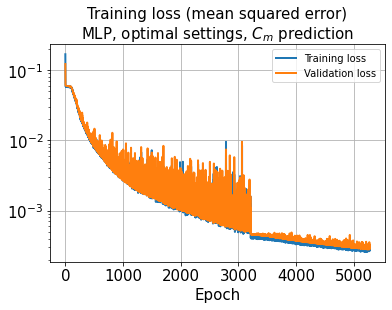

In [34]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

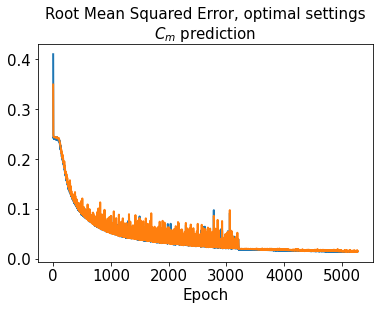

In [35]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

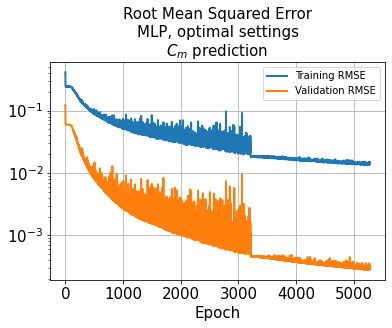

In [36]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [37]:
train_results = model.evaluate(x_train, y_train)

329/329 [==============================] - 1s 4ms/step - loss: 2.6616e-04 - rmse: 0.0137


In [38]:
val_results = model.evaluate(x_val, y_val)

94/94 [==============================] - 0s 3ms/step - loss: 2.8994e-04 - rmse: 0.0145


In [39]:
test_results = model.evaluate(x_test, y_test)

47/47 [==============================] - 0s 3ms/step - loss: 2.7739e-04 - rmse: 0.0141


In [40]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

47/47 [==============================] - 0s 1ms/step


In [41]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [42]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [43]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [44]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [45]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [46]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.03150254689836188
1.0104903969988777


In [47]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.0331076601815651
1.063938363321847


In [48]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.0321804629857987
1.066787356145479


In [49]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [50]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [51]:
model_directory = "D:\\TrainedModels\\20221229"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221229unsteadyValidation_MLP_3beta_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [52]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [53]:
os.chdir(storage_dir)

In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [56]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [57]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [58]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [59]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [60]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

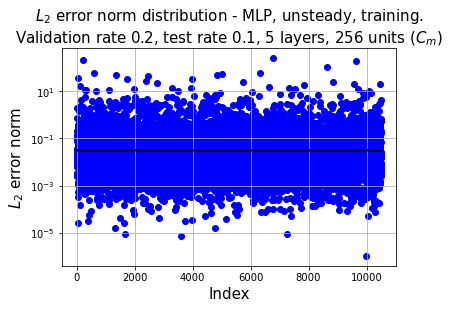

In [61]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

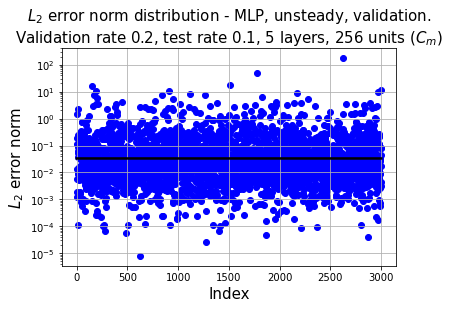

In [62]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

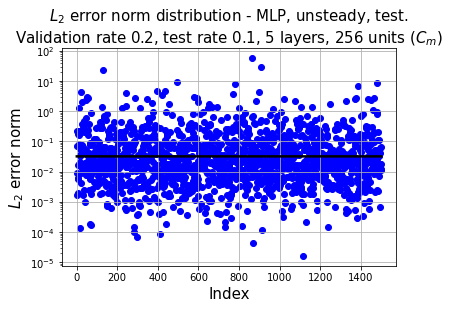

In [63]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [64]:
predicted = model.predict(x)

469/469 [==============================] - 1s 1ms/step


In [65]:
tTrain = t[index_train]+10
tVal = t[index_val]+10
tTest = t[index_test]+10

In [66]:
index_train.shape

(10500,)

In [67]:
max(predicted)

array([1.0012988], dtype=float32)

In [68]:
l2_error(denormalize(predicted), denormalize(y))

0.043695566715576076

In [69]:
l2_error(predicted, y)

0.031903178744096726

In [70]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [71]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [72]:
x[:,0] *= 5
x[:,0] += 10

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0246


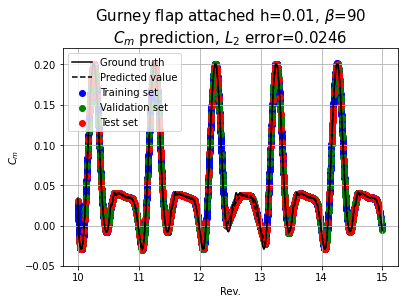

L2 error of Cm: 0.0296


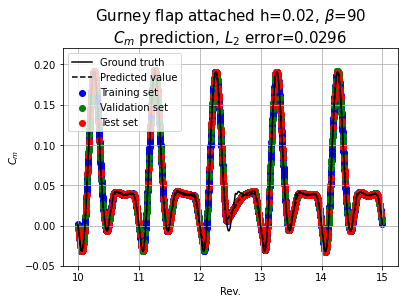

L2 error of Cm: 0.0403


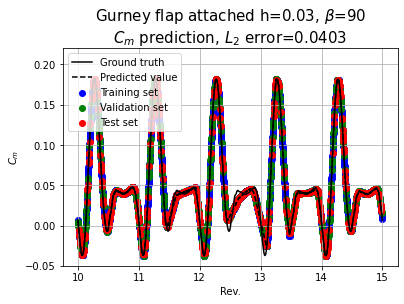

In [74]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [75]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
#     title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm), 'b--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0246


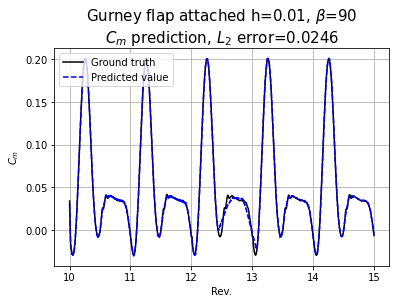

L2 error of Cm: 0.0296


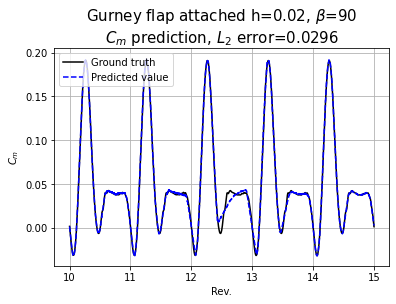

L2 error of Cm: 0.0403


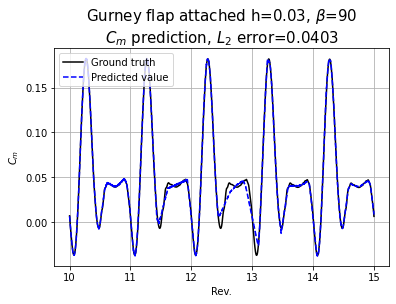

In [76]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0246


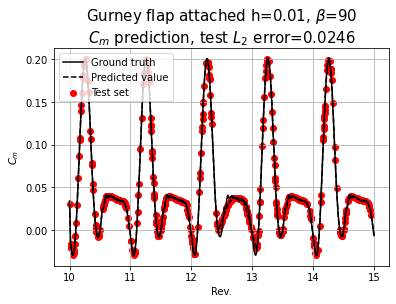

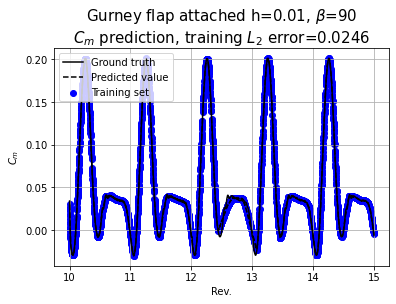

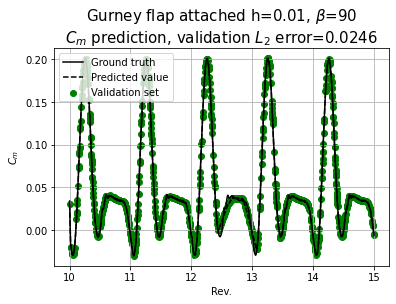

L2 error of Cm: 0.0296


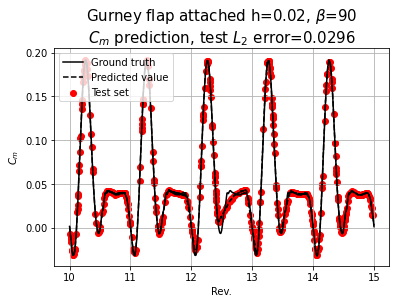

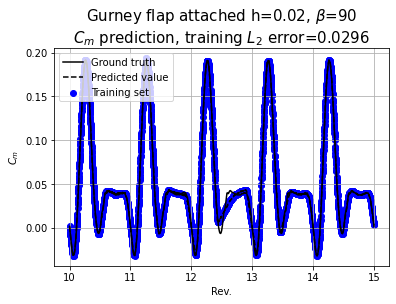

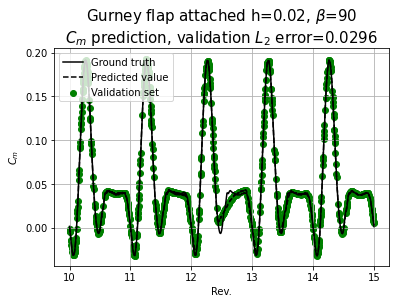

L2 error of Cm: 0.0403


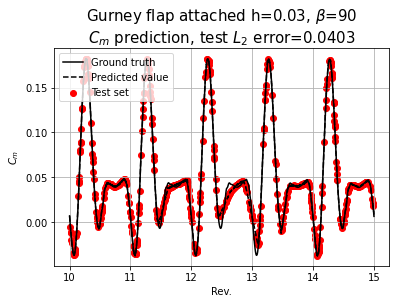

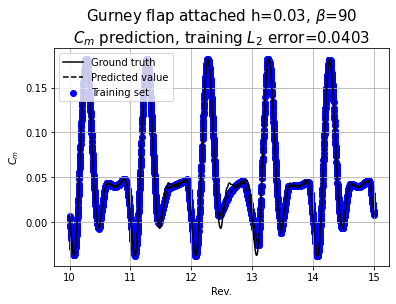

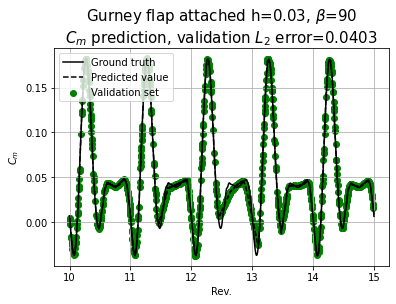

In [79]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    title_train = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_Cm)
    title_val = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_Cm)
    title_test = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_Cm)
    title_Cm = title_n_Cm
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
    
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"training.jpg"
    savename2 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"validation.jpg"
    savename3 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+"test.jpg"
#     Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

    # CD graph plot
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_test, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename3, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_train, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.plot(t[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:5000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
#     plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_val, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()